In [0]:
# The used dataset can be found here(training.csv): 
# https://www.kaggle.com/c/DontGetKicked/data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

# Data preparation
from sklearn_pandas import CategoricalImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN

# Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
  VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import roc_curve, classification_report

# Cross-validation, Misc
from sklearn.model_selection import train_test_split, StratifiedKFold, \
  cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline

DATA = 'training.csv'
TEST_SIZE = 0.3
KFOLD_SPLITS = 10
SEED = 7
SCORE_ACC = 'accuracy'
SCORE_AUC = 'roc_auc'
MAX_ITER = 1000

# Loading data..
data = pd.read_csv(DATA)
data.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [0]:
# Getting to know our data..
data.dtypes

RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

In [0]:
# We notice that we have an unbalanced labeled dataset.
data.groupby("IsBadBuy").size()

IsBadBuy
0    64007
1     8976
dtype: int64

In [0]:
# Seperating target attribute from the rest of the data..
target = data.iloc[:, 1]
data.drop("IsBadBuy", axis = 1, inplace = True)

In [0]:
# Finding redundant data: attributes with high amount of missing values
print('datacount:', len(data))
print('Nan in data:\n', data.isnull().sum())

datacount: 72983
Nan in data:
 RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentAuctionCleanP

In [0]:
# Finding redundant data: highly correlated attributes
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,RefId,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
RefId,1.000000,0.010580,-0.025404,0.013110,-0.026553,-0.011568,-0.015704,-0.032208,-0.034324,-0.008742,-0.013015,-0.021616,-0.024369,0.032896,0.131898,-0.011873,-0.048851,-0.023478
VehYear,0.010580,1.000000,-0.957957,0.259660,-0.283719,0.581146,0.532927,0.581191,0.539230,0.590820,0.548426,0.598490,0.558669,0.280791,0.068276,0.349965,0.057380,-0.268696
VehicleAge,-0.025404,-0.957957,1.000000,-0.250801,0.319794,-0.565690,-0.518810,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.268269,-0.074857,-0.312329,-0.024771,0.259310
WheelTypeID,0.013110,0.259660,-0.250801,1.000000,-0.213558,-0.095471,-0.129597,-0.072700,-0.102019,-0.088597,-0.121211,-0.074420,-0.102488,0.187199,0.007901,-0.162826,-0.006747,-0.132798
VehOdo,-0.026553,-0.283719,0.319794,-0.213558,1.000000,-0.017022,0.024617,0.031306,0.063165,-0.028568,0.012107,0.015811,0.048005,-0.288456,-0.053041,-0.062008,0.029556,0.411718
MMRAcquisitionAuctionAveragePrice,-0.011568,0.581146,-0.565690,-0.095471,-0.017022,1.000000,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.107734,0.045694,0.789840,0.038818,-0.050417
MMRAcquisitionAuctionCleanPrice,-0.015704,0.532927,-0.518810,-0.129597,0.024617,0.990347,1.000000,0.902718,0.918242,0.923610,0.932114,0.860716,0.871203,0.062502,0.040675,0.781516,0.038667,-0.020644
MMRAcquisitionRetailAveragePrice,-0.032208,0.581191,-0.460854,-0.072700,0.031306,0.910391,0.902718,1.000000,0.990201,0.851647,0.849407,0.913108,0.906054,0.107516,0.035489,0.746126,0.080627,-0.053444
MMRAcquisitonRetailCleanPrice,-0.034324,0.539230,-0.426382,-0.102019,0.063165,0.910187,0.918242,0.990201,1.000000,0.846914,0.855689,0.903188,0.906810,0.069676,0.031284,0.744966,0.077670,-0.026933
MMRCurrentAuctionAveragePrice,-0.008742,0.590820,-0.575607,-0.088597,-0.028568,0.937817,0.923610,0.851647,0.846914,1.000000,0.990329,0.915073,0.912231,0.111363,0.048965,0.778738,0.039876,-0.056798


In [0]:
# The purchase date attribute is too specific, but the month part seems
# to have some significance over our bad buys. Thus, we extract it into
# a seperate feature and we will discard the old one.
data['MonthOfPurchase'] = pd.DatetimeIndex(data['PurchDate']).month

In [0]:
# Dropping: a) Attributes not providing actual information.
#           b) Attributes with high missing values.
#           c) Some of the highly correlated attributes.
data.drop(["RefId", "PurchDate", "VehYear", "Model", \
  "SubModel", "WheelType", \
  "PRIMEUNIT", "AUCGUART"], axis = 1, inplace = True)

In [0]:
# Imputing categorical columns with most frequent values..
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()
catImputer = CategoricalImputer(strategy='most_frequent')
for col in categorical_cols:
  data[col] = catImputer.fit_transform(data[col])

In [0]:
# Imputing numerical columns with median values. Before imputation,
# we have to change the datatype from Float64 to int.
numerical_cols = data.columns.drop(categorical_cols).tolist()
data[numerical_cols] = data[numerical_cols].fillna(-1)
data[numerical_cols] = data[numerical_cols].astype(np.int64)
data[numerical_cols] = data[numerical_cols].replace(-1, np.nan)
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

In [0]:
# One-hot encoding categorical data to dummy attributes..
data = pd.get_dummies(data[categorical_cols])

In [0]:
# Standardizing our data, so as to follow normal distribution with 
# zero mean and unit variance. This primarily helps when applying 
# Logistic Regression.
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [0]:
# We have to balance our dataset. We are going to achieve this by downsampling
# the good buys.
xBad = data[target == 1] 
yBad = target[target == 1] 
xGood = data[target == 0]
yGood = target[target == 0]
print('Before balancing:\n\tGood buys(0): {}, '\
  'Bad buys(1): {}'.format(len(xGood), len(xBad)))
xGoodBalanced = xGood[:len(xBad), :]
yGoodBalanced = yGood[:len(xBad)]
print('After balancing:\n\tGood buys(0): {}, '\
  'Bad buys(1): {}'.format(len(xGoodBalanced), len(xBad)))
dataBalanced = np.concatenate((xGoodBalanced, xBad), axis=0)
targetBalanced = np.concatenate((yGoodBalanced, yBad), axis=0)

Before balancing:
	Good buys(0): 64007, Bad buys(1): 8976
After balancing:
	Good buys(0): 8976, Bad buys(1): 8976


In [0]:
# Alternative strategy: Oversample the bad buys
# sm = SMOTE(ratio = 'minority')
# dataBalanced, targetBalanced = sm.fit_sample(data, target)

In [0]:
# Seperating training-validating from testing dataset
xTrain_Val, xTest, yTrain_Val, yTest = train_test_split(dataBalanced, \
  targetBalanced, test_size = TEST_SIZE, random_state = SEED)

In [0]:
# Initializing k-fold cross validation model
kfold = StratifiedKFold(n_splits = KFOLD_SPLITS, shuffle = True, \
  random_state = SEED)
clfs = []

In [0]:
def produceROCs():
  for clf in clfs:
    hlp = cross_val_predict(clf['clf'], xTrain_Val, yTrain_Val, \
      method = 'predict_proba', n_jobs = -1)
    fpr, tpr, thresholds = roc_curve(yTrain_Val, hlp[:, 1])
    plt.plot(fpr, tpr, label = clf['label'])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.style.use('fivethirtyeight')
  plt.title("ROC Curves")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc='best')
  plt.show()

In [0]:
# Proceeding to validation phase..
# First, we are going to use Logistic Regression, with many different C values.
pipelineEstimator = Pipeline([('clf', \
  LogisticRegression(max_iter = MAX_ITER, random_state = SEED))])
c_space = np.logspace(-5, 1, 10)
parameters = [{'clf__C': c_space}]
grid_obj = GridSearchCV(estimator = pipelineEstimator, \
  param_grid = parameters, scoring = SCORE_ACC, n_jobs = -1)
grid_obj.fit(xTrain_Val, yTrain_Val)

print(pd.concat([pd.DataFrame(grid_obj.cv_results_["params"]), \
  pd.DataFrame(np.round(grid_obj.cv_results_["mean_test_score"], 4), \
  columns = ["acc"])],axis=1))

      clf__C     acc
0   0.000010  0.7610
1   0.000046  0.7641
2   0.000215  0.7695
3   0.001000  0.7714
4   0.004642  0.7691
5   0.021544  0.7661
6   0.100000  0.7655
7   0.464159  0.7652
8   2.154435  0.7655
9  10.000000  0.7651


In [0]:
# Getting roc-auc score for the superior LR classificator..
opt_c = c_space[np.argmax(grid_obj.cv_results_["mean_test_score"])]
opt_clf = LogisticRegression(C = opt_c, max_iter = MAX_ITER, \
  random_state = SEED)
clfs.append({'label': 'LR', 'clf': opt_clf})
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_AUC, n_jobs = -1)
print('Logistic Regression with C = {} -> roc_auc: {:.3}' \
  ' (+/- {:.3})'.format(opt_c, res.mean(), res.std()))

Logistic Regression with C = 0.001 -> roc_auc: 0.838 (+/- 0.00909)


In [0]:
# Now, we are going to use a Random Forest classificator. We start again with
# hyperparameter tuning.
pipelineEstimator = Pipeline([('clf', \
  RandomForestClassifier(random_state = SEED))])
max_depth = [int(x) for x in np.linspace(2, 20, num = 5)]
max_features = ['auto', 'sqrt']
parameters = [{'clf__max_depth': max_depth, \
  'clf__max_features': max_features}]
grid_obj = GridSearchCV(estimator = pipelineEstimator, \
  param_grid = parameters, scoring = SCORE_ACC, n_jobs = -1)
grid_obj.fit(xTrain_Val, yTrain_Val)

print(pd.concat([pd.DataFrame(grid_obj.cv_results_["params"]), \
  pd.DataFrame(np.round(grid_obj.cv_results_["mean_test_score"], 4), \
  columns = ["acc"])],axis=1))

   clf__max_depth clf__max_features     acc
0               2              auto  0.7504
1               2              sqrt  0.7504
2               6              auto  0.8166
3               6              sqrt  0.8166
4              11              auto  0.8648
5              11              sqrt  0.8648
6              15              auto  0.8761
7              15              sqrt  0.8761
8              20              auto  0.8795
9              20              sqrt  0.8795


In [0]:
# Getting roc-auc score for the superior RF classificator..
opt_depth = max_depth[np.argmax(grid_obj.cv_results_["mean_test_score"]) // 2]
opt_feat = max_features[np.argmax(grid_obj.cv_results_["mean_test_score"]) % 2]
opt_clf = RandomForestClassifier(max_depth = opt_depth, \
  max_features = opt_feat, random_state = SEED)
clfs.append({'label': 'RF', 'clf': opt_clf})
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_AUC, n_jobs = -1)
print('Random Forest with max_depth = {}, max_features = {} -> roc_auc: {:.3}' \
  ' (+/- {:.3})'.format(opt_depth, opt_feat, res.mean(), res.std()))

Random Forest with max_depth = 20, max_features = auto -> roc_auc: 0.92 (+/- 0.0054)


In [0]:
# Next, we are going to use an AdaBoost classifier.
pipelineEstimator = Pipeline([('clf', \
  AdaBoostClassifier(random_state = SEED))])
n_estimators = [10, 100, 200, 500, 1000]
learning_rate = [0.01, 0.1]
parameters = [{'clf__n_estimators': n_estimators, \
               'clf__learning_rate': learning_rate}]
grid_obj = GridSearchCV(estimator = pipelineEstimator, \
  param_grid = parameters, scoring = SCORE_ACC, n_jobs = -1, verbose = True)
grid_obj.fit(xTrain_Val, yTrain_Val)

print(pd.concat([pd.DataFrame(grid_obj.cv_results_["params"]), \
  pd.DataFrame(np.round(grid_obj.cv_results_["mean_test_score"], 4), \
  columns = ["acc"])],axis=1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.5min finished


   clf__learning_rate  clf__n_estimators     acc
0                0.01                 10  0.5859
1                0.01                100  0.6989
2                0.01                200  0.7164
3                0.01                500  0.7228
4                0.01               1000  0.7433
5                0.10                 10  0.6989
6                0.10                100  0.7440
7                0.10                200  0.7562
8                0.10                500  0.7601
9                0.10               1000  0.7599


In [0]:
# Getting roc-auc score for the superior Ada classificator..
opt_est = n_estimators[np.argmax(grid_obj.cv_results_["mean_test_score"]) % 5]
opt_learn = learning_rate[np.argmax(grid_obj.cv_results_["mean_test_score"]) // 5]
opt_clf = AdaBoostClassifier(n_estimators = opt_est, \
  learning_rate = opt_learn, random_state = SEED)
clfs.append({'label': 'Ada', 'clf': opt_clf})
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_AUC, n_jobs = -1)
print('AdaBoost with n_estimators = {}, learning_rate = {} -> roc_auc: {:.3}' \
  ' (+/- {:.3})'.format(opt_est, opt_learn, res.mean(), res.std()))

AdaBoost with n_estimators = 500, learning_rate = 0.1 -> roc_auc: 0.838 (+/- 0.00945)


In [0]:
# Next up is (Gaussian) Naive Bayes.
opt_clf = GaussianNB()
clfs.append({'label': 'GNB', 'clf': opt_clf})
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_ACC, n_jobs = -1)
print('GNB -> accuracy: {:.3}' \
  ' (+/- {:.3})'.format(res.mean(), res.std()))
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_AUC, n_jobs = -1)
print('       roc_auc: {:.3}' \
  ' (+/- {:.3})'.format(res.mean(), res.std()))

GNB -> accuracy: 0.626 (+/- 0.0114)
       roc_auc: 0.79 (+/- 0.0143)


In [26]:
# Continuing with Multi-Layer Perceptron..
pipelineEstimator = Pipeline([('clf', \
  MLPClassifier(random_state = SEED, max_iter = MAX_ITER))])
alpha = np.linspace(0.0001, 1, 4)
activation = ['tanh', 'relu', 'logistic']
solver = ['sgd', 'adam', 'lbfgs']
parameters = [{
    'clf__alpha': alpha, \
    'clf__activation': activation, \
    'clf__solver': solver}]
grid_obj = GridSearchCV(estimator = pipelineEstimator, \
  param_grid = parameters, scoring = SCORE_ACC, n_jobs = -1, verbose = True)
grid_obj.fit(xTrain_Val, yTrain_Val)

print(pd.concat([pd.DataFrame(grid_obj.cv_results_["params"]), \
  pd.DataFrame(np.round(grid_obj.cv_results_["mean_test_score"], 4), \
  columns = ["acc"])],axis=1))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 113.7min finished


   clf__activation  clf__alpha clf__solver     acc
0             tanh      0.0001         sgd  0.8523
1             tanh      0.0001        adam  0.8403
2             tanh      0.0001       lbfgs  0.8284
3             tanh      0.3334         sgd  0.8684
4             tanh      0.3334        adam  0.8613
5             tanh      0.3334       lbfgs  0.8435
6             tanh      0.6667         sgd  0.8763
7             tanh      0.6667        adam  0.8741
8             tanh      0.6667       lbfgs  0.8442
9             tanh      1.0000         sgd  0.8795
10            tanh      1.0000        adam  0.8795
11            tanh      1.0000       lbfgs  0.8488
12            relu      0.0001         sgd  0.8541
13            relu      0.0001        adam  0.8461
14            relu      0.0001       lbfgs  0.8361
15            relu      0.3334         sgd  0.8686
16            relu      0.3334        adam  0.8642
17            relu      0.3334       lbfgs  0.8442
18            relu      0.6667 

In [29]:
# Getting roc-auc score for the superior MLP classificator..
opt_alpha = alpha[np.argmax(grid_obj.cv_results_["mean_test_score"]) % 12 // 3]
opt_activ = activation[np.argmax(grid_obj.cv_results_["mean_test_score"]) // 12]
opt_solver = solver[np.argmax(grid_obj.cv_results_["mean_test_score"]) % 3]
opt_clf = MLPClassifier(alpha = opt_alpha, activation = opt_activ, \
  solver = opt_solver, random_state = SEED, max_iter = MAX_ITER)
clfs.append({'label': 'MLP', 'clf': opt_clf})
res = cross_val_score(opt_clf, xTrain_Val, yTrain_Val, cv = kfold, \
  scoring = SCORE_AUC, n_jobs = -1)
print('MLP with activation = {}, solver = {}, alpha = {} -> roc_auc: {:.3}' \
  ' (+/- {:.3})'.format(opt_activ, opt_solver, opt_alpha,  res.mean(), res.std()))

MLP with activation = relu, solver = sgd, alpha = 1.0 -> roc_auc: 0.919 (+/- 0.00629)


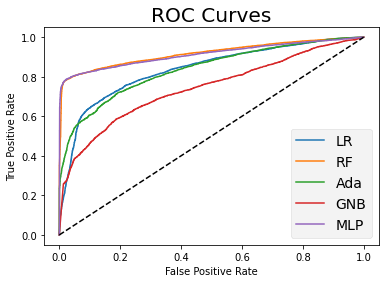

In [40]:
produceROCs()

In [43]:
# Finally, for the best classificator setup encountered, 
# we will proceed to the testing phase.
best_clf = MLPClassifier(alpha = opt_alpha, activation = opt_activ, \
  solver = opt_solver, random_state = SEED, max_iter = 1000)
best_clf.fit(xTrain_Val,yTrain_Val)
yTrain_Valpred = best_clf.predict(xTrain_Val)
print('Predicting training-validating dataset:\n', \
  classification_report(yTrain_Val, yTrain_Valpred))
yPred = best_clf.predict(xTest)
report = classification_report(yTest, yPred)
print('Predicting testing dataset:\n', report)

Predicting training-validating dataset:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      6329
           1       0.98      0.83      0.90      6237

    accuracy                           0.91     12566
   macro avg       0.92      0.91      0.91     12566
weighted avg       0.92      0.91      0.91     12566

Predicting testing dataset:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      2647
           1       0.95      0.79      0.86      2739

    accuracy                           0.87      5386
   macro avg       0.88      0.87      0.87      5386
weighted avg       0.88      0.87      0.87      5386



[0.81, 0.95, 0.88]
[0.95, 0.79, 0.86]
plotMat: [[0.81, 0.95, 0.88], [0.95, 0.79, 0.86]]
support: [2647, 2739]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


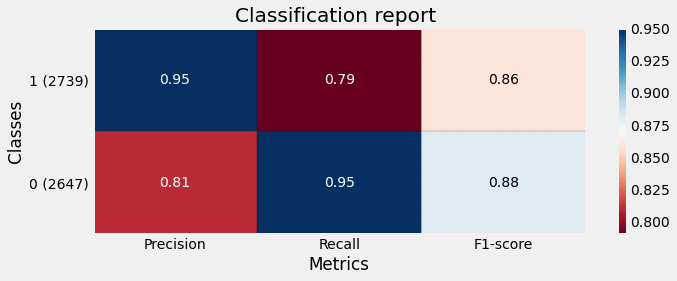

In [44]:
# Plotting classification report..
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), \
      pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, \
  figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', \
      linewidths=0.2, cmap=cmap)
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim( (0, AUC.shape[1]) )
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    plt.colorbar(c)
    show_values(c)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, \
  title='Classification report ', cmap='RdBu'):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)
    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))
    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, \
      sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, \
      yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

plot_classification_report(report)
plt.show()